# Introdução

Este notebook classifica indivíduos como introvertidos ou extrovertidos com base em características de comportamento social do conjunto de dados de personalidade.
Serão utilizados os modelos de KNN, Decision Tree, Nayve Bayes e Random Forest.
O objetivo é atingir uma acurácia de 80%

# Configuração do Ambiente

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer

# Carga do Dataset e Análise dos Dados

Este dataset contém dados sobre várias pessoas, aonde cada linha representa uma pessoa. As colunas incluem informações sobre comportamentos como tempo gasto sozinho, participação em eventos sociais e engajamento em redes sociais.

Descrição de cada coluna:
- Time_spent_Alone: Horas passadas sozinho diariamente (0–11).
- Stage_fear: Presença de medo de palco (Sim/Não).
- Social_event_attendance: Frequência de participação em eventos sociais (0–10).
- Going_outside: Frequência com que sai de casa (0–7).
- Drained_after_socializing: Sensação de exaustão após socializar (Sim/Não).
- Friends_circle_size: Número de amigos próximos (0–15).
- Post_frequency: Frequência de postagens nas redes sociais (0–10).
- Personality: Variável alvo (Extrovertido/Introvertido).


In [2]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/MatheusPiaia/MVP-qualidade-seguranca-sistemas-inteligentes/refs/heads/main/personality_dataset.csv"

# Lê o arquivo
data = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
data.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [3]:
# Mostrar informações básicas
print("Dataset Shape:", data.shape)
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

# Definir colunas numéricas e categóricas
numeric_columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
categorical_columns = ['Stage_fear', 'Drained_after_socializing']
target_column = 'Personality'

# Verificar os valores categóricos
for col in categorical_columns:
    print(f"\nUnique values in {col}:")
    print(data[col].value_counts(dropna=False))

Dataset Shape: (2900, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB
None

Missing Values:
Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency            

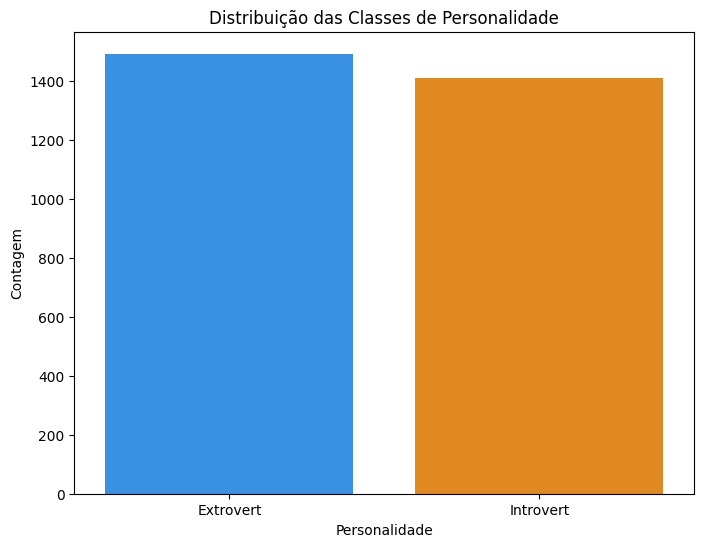

In [4]:
# Distribuição das classes do dataset
plt.figure(figsize=(8, 6))
sns.countplot(x=target_column, data=data, palette=['#1E90FF', '#FF8C00'])
plt.title('Distribuição das Classes de Personalidade')
plt.xlabel('Personalidade')
plt.ylabel('Contagem')
plt.show()

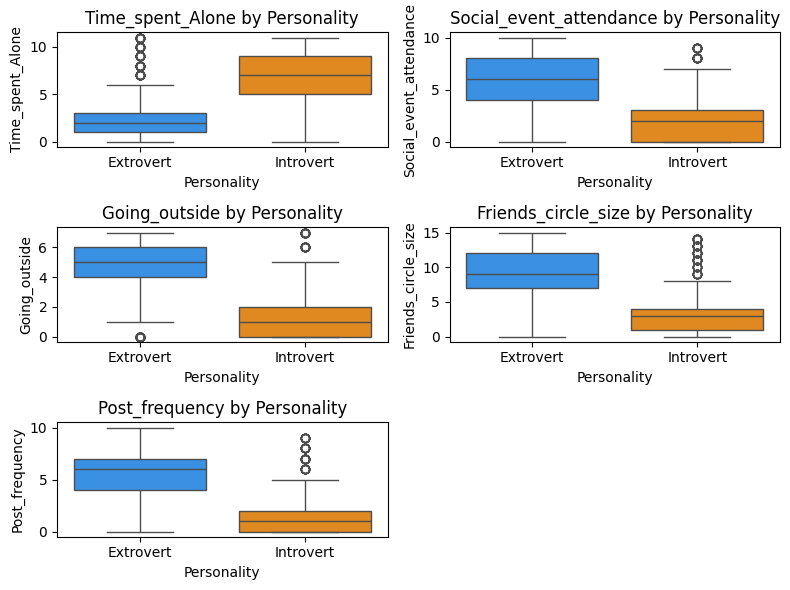

In [5]:
# Distribuições das variáveis numéricas por classe
plt.figure(figsize=(8, 6))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=target_column, y=col, data=data, palette=['#1E90FF', '#FF8C00'])
    plt.title(f'{col} by Personality')
plt.tight_layout()
plt.show()

# Pré processamento dos dados

In [6]:
#Codificar variável alvo

label_encoder = LabelEncoder()
data[target_column] = label_encoder.fit_transform(data[target_column])
label_encoder_filename = 'label_encoder.pkl'
with open("../encoder/"+label_encoder_filename, 'wb') as file:
    pickle.dump(label_encoder, file)

#Separar X e y

X = data[numeric_columns + categorical_columns]
y = data[target_column]

#Função para cap dos outliers
# --------------------------
def cap_outliers(X_df, numeric_columns):
    X_df = pd.DataFrame(X_df, columns=numeric_columns)
    for col in numeric_columns:
        Q1 = X_df[col].quantile(0.25)
        Q3 = X_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        X_df[col] = X_df[col].clip(lower=lower, upper=upper)
    return X_df.values

#Transformadores
# --------------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# --------------------------
#ColumnTransformer
# --------------------------
data[numeric_columns] = cap_outliers(data[numeric_columns], numeric_columns)
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

In [7]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 42 # semente aleatória

# Separação em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

# Modelagem e Inferência

## Criação e avaliação modelos

LR: 0.9345 (+/- 0.0136) - Tempo: 0.27s
LR: 0.9345 (+/- 0.0136) - Tempo: 0.27s
KNN: 0.9302 (+/- 0.0166) - Tempo: 0.18s
KNN: 0.9302 (+/- 0.0166) - Tempo: 0.18s
CART: 0.8879 (+/- 0.0152) - Tempo: 0.14s
CART: 0.8879 (+/- 0.0152) - Tempo: 0.14s
NB: 0.9384 (+/- 0.0167) - Tempo: 0.12s
NB: 0.9384 (+/- 0.0167) - Tempo: 0.12s
SVM: 0.9388 (+/- 0.0168) - Tempo: 0.38s
SVM: 0.9388 (+/- 0.0168) - Tempo: 0.38s
Bagging: 0.9246 (+/- 0.0147) - Tempo: 2.56s
Bagging: 0.9246 (+/- 0.0147) - Tempo: 2.56s
RF: 0.9284 (+/- 0.0130) - Tempo: 1.69s
RF: 0.9284 (+/- 0.0130) - Tempo: 1.69s
ET: 0.9194 (+/- 0.0125) - Tempo: 1.45s
ET: 0.9194 (+/- 0.0125) - Tempo: 1.45s
Ada: 0.9246 (+/- 0.0156) - Tempo: 1.47s
Ada: 0.9246 (+/- 0.0156) - Tempo: 1.47s
GB: 0.9388 (+/- 0.0168) - Tempo: 1.44s
GB: 0.9388 (+/- 0.0168) - Tempo: 1.44s
Voting: 0.9384 (+/- 0.0167) - Tempo: 0.54s
Voting: 0.9384 (+/- 0.0167) - Tempo: 0.54s

⏱️ Tempo total: 10.25 segundos


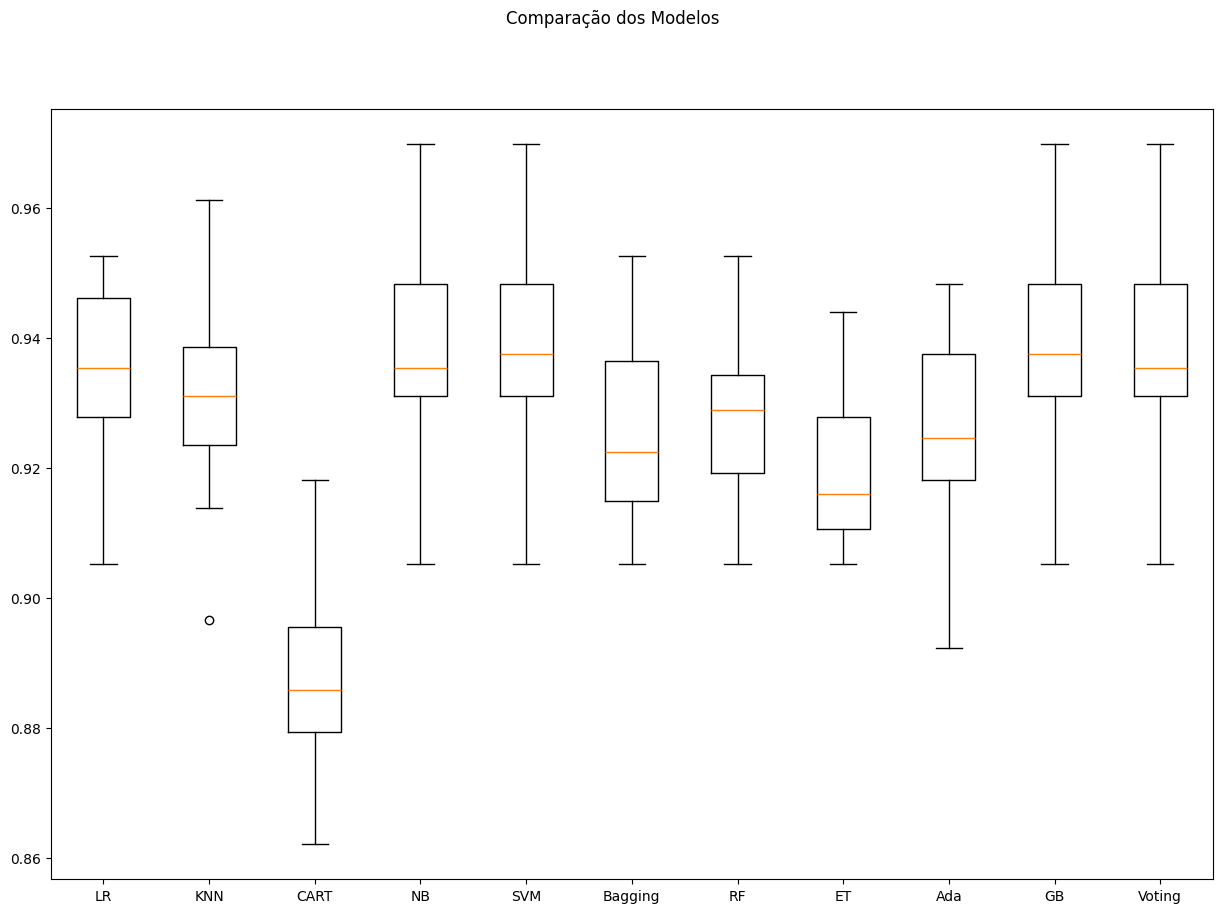

In [8]:
np.random.seed(42) # definindo uma semente global

# Lista que armazenará os pipelines
pipelines = []

# Criando os modelos e adicionando-os na lista de modelos
models = []
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Cronometro total
start_total = time.time()

# Avaliação dos modelos (treinamento)
for name, model in models:
    start_model = time.time()
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), (name, model)])
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=scoring)

    end_model = time.time()

    results.append(cv_results)
    names.append(name)

    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    duration = end_model - start_model
    msg = f"{name}: {cv_results.mean():.4f} (+/- {cv_results.std():.4f}) - Tempo: {duration:.2f}s"
    print(msg)
    print(msg)

# Mostrar tempo total de execução da célula
end_total = time.time()
print(f"\n⏱️ Tempo total: {end_total - start_total:.2f} segundos")

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Padronização e Normalização dos Dados

Utilizaremos o StandardScaler (padronização do conjunto de dados) e MinMaxScaler (normalização do conjunto de dados) para testar o quando os dados são desbalanceados e/ou sensíveis a escala, buscando aumentar nossa acurácia.

StandardScaler
StandardScaler padroniza os dados, ou seja, remove a média e escala os dados para que tenham uma variância unitária. Ele transforma os dados para que a média de cada feature seja 0 e a variância seja 1.

MinMaxScaler
MinMaxScaler escala e transforma os dados para um intervalo específico, geralmente entre 0 e 1. Ele transforma os dados para que o menor valor de uma feature seja 0 e o maior valor seja 1.


LR-orig: 0.934 (+/- 0.014) - Tempo: 0.45s
KNN-orig: 0.930 (+/- 0.017) - Tempo: 0.49s
CART-orig: 0.888 (+/- 0.015) - Tempo: 0.35s
NB-orig: 0.938 (+/- 0.017) - Tempo: 0.28s
SVM-orig: 0.939 (+/- 0.017) - Tempo: 0.77s
Bag-orig: 0.925 (+/- 0.015) - Tempo: 5.93s
RF-orig: 0.928 (+/- 0.013) - Tempo: 3.36s
ET-orig: 0.919 (+/- 0.013) - Tempo: 4.70s
Ada-orig: 0.925 (+/- 0.016) - Tempo: 3.68s
GB-orig: 0.939 (+/- 0.017) - Tempo: 3.12s
Vot-orig: 0.938 (+/- 0.017) - Tempo: 1.50s
LR-padr: 0.929 (+/- 0.015) - Tempo: 0.57s
KNN-padr: 0.934 (+/- 0.015) - Tempo: 0.55s
CART-padr: 0.888 (+/- 0.015) - Tempo: 0.40s
NB-padr: 0.938 (+/- 0.017) - Tempo: 0.35s
SVM-padr: 0.939 (+/- 0.017) - Tempo: 1.19s
Bag-padr: 0.922 (+/- 0.014) - Tempo: 6.46s
RF-padr: 0.928 (+/- 0.014) - Tempo: 4.17s
ET-padr: 0.917 (+/- 0.014) - Tempo: 2.80s
Ada-padr: 0.924 (+/- 0.015) - Tempo: 4.63s
GB-padr: 0.939 (+/- 0.017) - Tempo: 3.86s
Vot-padr: 0.938 (+/- 0.016) - Tempo: 1.45s
LR-norm: 0.934 (+/- 0.014) - Tempo: 0.54s
KNN-norm: 0.934 (+/-

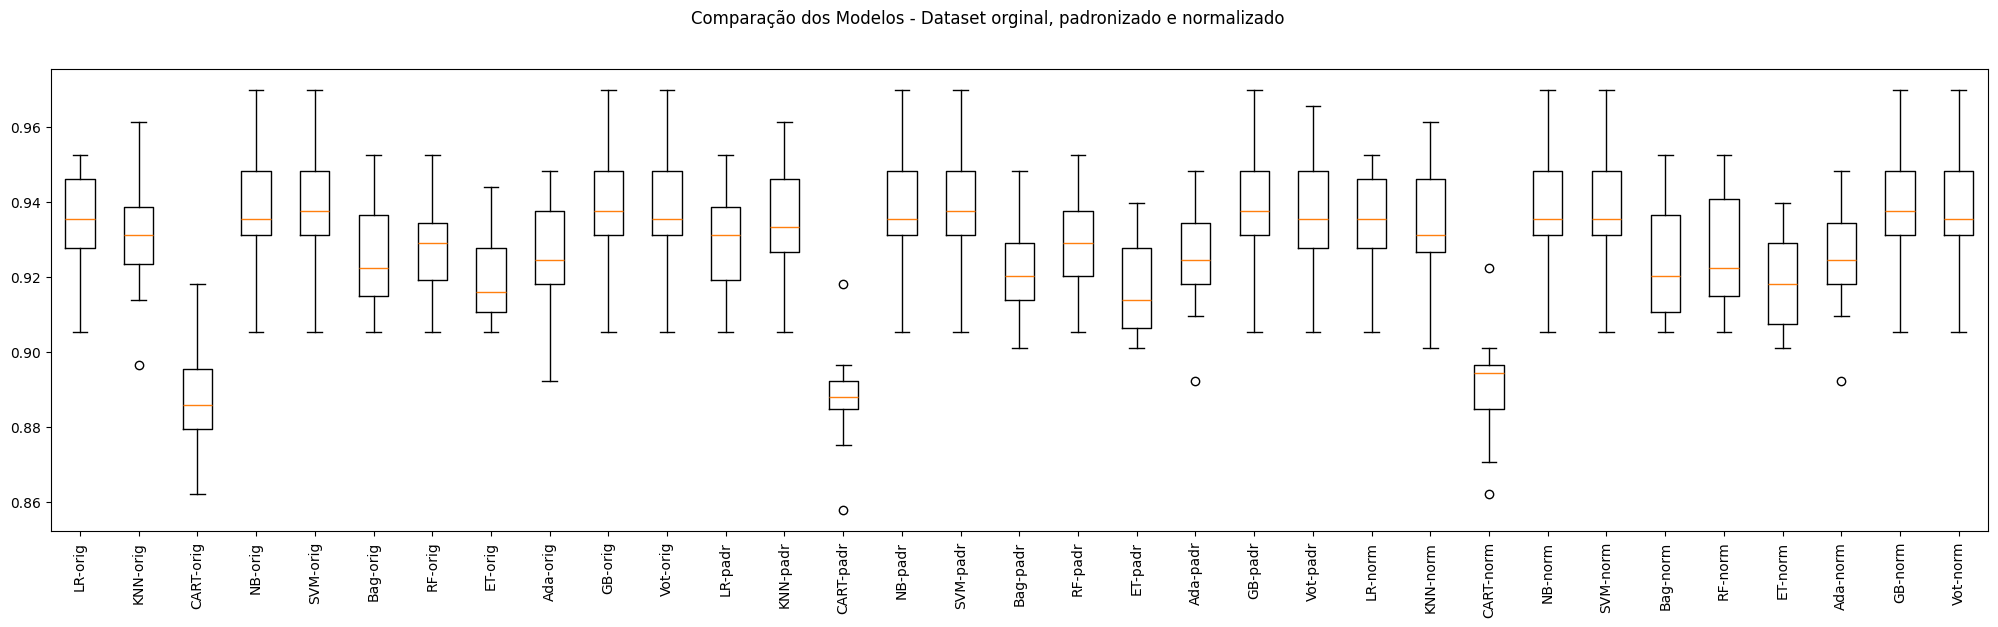

In [16]:
np.random.seed(42) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines
# A ordem de execução é da esquerda para a direita.

# Dataset original (aplicando o preprocessor antes do modelo)
pipelines.append(('LR-orig', Pipeline([('preprocessor', preprocessor), reg_log])))
pipelines.append(('KNN-orig', Pipeline([('preprocessor', preprocessor), knn])))
pipelines.append(('CART-orig', Pipeline([('preprocessor', preprocessor), cart])))
pipelines.append(('NB-orig', Pipeline([('preprocessor', preprocessor), naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([('preprocessor', preprocessor), svm])))
pipelines.append(('Bag-orig', Pipeline([('preprocessor', preprocessor), bagging])))
pipelines.append(('RF-orig', Pipeline([('preprocessor', preprocessor), random_forest])))
pipelines.append(('ET-orig', Pipeline([('preprocessor', preprocessor), extra_trees])))
pipelines.append(('Ada-orig', Pipeline([('preprocessor', preprocessor), adaboost])))
pipelines.append(('GB-orig', Pipeline([('preprocessor', preprocessor), gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([('preprocessor', preprocessor), voting])))


# Dataset Padronizado (aplicando o preprocessor e StandardScaler antes do modelo)
pipelines.append(('LR-padr', Pipeline([('preprocessor', preprocessor), standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([('preprocessor', preprocessor), standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([('preprocessor', preprocessor), standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([('preprocessor', preprocessor), standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([('preprocessor', preprocessor), standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([('preprocessor', preprocessor), standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([('preprocessor', preprocessor), standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([('preprocessor', preprocessor), standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([('preprocessor', preprocessor), standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([('preprocessor', preprocessor), standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([('preprocessor', preprocessor), standard_scaler, voting])))


# Dataset Normalizado (aplicando o preprocessor e MinMaxScaler antes do modelo)
pipelines.append(('LR-norm', Pipeline([('preprocessor', preprocessor), min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([('preprocessor', preprocessor), min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([('preprocessor', preprocessor), min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([('preprocessor', preprocessor), min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([('preprocessor', preprocessor), min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([('preprocessor', preprocessor), min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([('preprocessor', preprocessor), min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([('preprocessor', preprocessor), min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([('preprocessor', preprocessor), min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([('preprocessor', preprocessor), min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([('preprocessor', preprocessor), min_max_scaler, voting])))

start_total = time.time()

# Executando os pipelines
for name, model in pipelines:
    start_model = time.time()

    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

    end_model = time.time()

    results.append(cv_results)
    names.append(name)

    duration = end_model - start_model
    msg = f"{name}: {cv_results.mean():.3f} (+/- {cv_results.std():.3f}) - Tempo: {duration:.2f}s"
    print(msg)  

end_total = time.time()
print(f"\n⏱️ Tempo total: {(end_total - start_total)/60:.2f} minutos")    

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## Otimização dos hiperpâremetros

A otimização de hiperparâmetros é o processo de encontrar os valores ideais para os hiperparâmetros de um modelo de machine learning. O objetivo é encontrar a combinação de hiperparâmetros que resulta no melhor desempenho do modelo.

Iremos utilizar o método de "Força Bruta" (Grid Search)
Como Funciona o Grid Search?
1. Definição do Espaço de Hiperparâmetros: Primeiro, define-se um conjunto de valores possíveis para cada hiperparâmetro.
2. Avaliação das Combinações: Em seguida, cada combinação possível desses valores é avaliada.
3. Seleção do Melhor Conjunto: A combinação de hiperparâmetros que produz o melhor desempenho é selecionada.

In [17]:
np.random.seed(42)  # Definindo uma semente global para este bloco

# Lista de modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(estimators=bases, voting='hard')))

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Lista de pipelines
pipelines = []

# Criando pipelines para cada modelo
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[('preprocessor', preprocessor), (name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[('preprocessor', preprocessor), standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[('preprocessor', preprocessor), min_max_scaler, (name, model)])))


# Definindo os parâmetros para GridSearchCV
param_grids = {
    'LR': {
        'LR__C': [0.01, 0.1, 1, 10, 100],
        'LR__solver': ['liblinear', 'saga']
    },
    'KNN': {
        'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'KNN__metric': ["euclidean", "manhattan", "minkowski"]
    },
    'CART': {
        'CART__max_depth': [None, 10, 20, 30, 40, 50],
        'CART__min_samples_split': [2, 5, 10],
        'CART__min_samples_leaf': [1, 2, 4]
    },
    'NB': {
        'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'SVM': {
        'SVM__C': [0.1, 1, 10, 100],
        'SVM__gamma': [1, 0.1, 0.01, 0.001],
        'SVM__kernel': ['rbf', 'linear']
    },
    'RF': {
        'RF__n_estimators': [10, 50, 100, 200],
        'RF__max_features': ['auto', 'sqrt', 'log2'],
        'RF__max_depth': [None, 10, 20, 30],
        'RF__min_samples_split': [2, 5, 10],
        'RF__min_samples_leaf': [1, 2, 4]
    },
    'ET': {
        'ET__n_estimators': [10, 50, 100, 200],
        'ET__max_features': ['auto', 'sqrt', 'log2'],
        'ET__max_depth': [None, 10, 20, 30],
        'ET__min_samples_split': [2, 5, 10],
        'ET__min_samples_leaf': [1, 2, 4]
    },
    'Ada': {
        'Ada__n_estimators': [10, 50, 100, 200],
        'Ada__learning_rate': [0.01, 0.1, 1, 10]
    },
    'GB': {
        'GB__n_estimators': [10, 50, 100, 200],
        'GB__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'GB__max_depth': [3, 5, 7, 9]
    },
    'Voting': {
        # Para VotingClassifier, geralmente não há hiperparâmetros para ajustar diretamente
        # Ajustar os hiperparâmetros dos estimadores base individualmente se necessário
    }
}

# Parâmetros de cross-validation e scoring
scoring = 'accuracy'
kfold = 5

start_total = time.time()

# Executando o GridSearchCV para cada pipeline
for name, pipeline in pipelines:    
    model_type = name.split('-')[0]
    if model_type in param_grids:
        param_grid = param_grids[model_type]
    else:
        param_grid = {}  # Para modelos que não têm parâmetros definidos

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # Imprimindo a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

end_total = time.time()
print(f"\n⏱️ Tempo total: {(end_total - start_total)/60:.2f} minutos")

#It took 53min

Modelo: LR-orig - Melhor: 0.938793 usando {'LR__C': 0.01, 'LR__solver': 'liblinear'}
Modelo: LR-padr - Melhor: 0.938362 usando {'LR__C': 0.01, 'LR__solver': 'liblinear'}
Modelo: LR-norm - Melhor: 0.938362 usando {'LR__C': 0.01, 'LR__solver': 'liblinear'}
Modelo: KNN-orig - Melhor: 0.938793 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 13}
Modelo: KNN-padr - Melhor: 0.938793 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 11}
Modelo: KNN-norm - Melhor: 0.938362 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 11}
Modelo: CART-orig - Melhor: 0.927586 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo: CART-padr - Melhor: 0.929310 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo: CART-norm - Melhor: 0.929741 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
Modelo: NB-orig - Melhor: 0.938362 usando {'NB__var_smoothing': 1e-09}
Mo

In [ ]:
#Modelo: LR-orig - Melhor: 0.938793 usando {'LR__C': 0.01, 'LR__solver': 'liblinear'}
#Modelo: LR-padr - Melhor: 0.938362 usando {'LR__C': 0.01, 'LR__solver': 'liblinear'}
#Modelo: LR-norm - Melhor: 0.938362 usando {'LR__C': 0.01, 'LR__solver': 'liblinear'}
#Modelo: KNN-orig - Melhor: 0.938793 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 13}
#Modelo: KNN-padr - Melhor: 0.938793 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 11}
#Modelo: KNN-norm - Melhor: 0.938362 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 11}
#Modelo: CART-orig - Melhor: 0.927586 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
#Modelo: CART-padr - Melhor: 0.929310 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
#Modelo: CART-norm - Melhor: 0.929741 usando {'CART__max_depth': 10, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
#Modelo: NB-orig - Melhor: 0.938362 usando {'NB__var_smoothing': 1e-09}
#Modelo: NB-padr - Melhor: 0.938362 usando {'NB__var_smoothing': 1e-09}
#Modelo: NB-norm - Melhor: 0.938362 usando {'NB__var_smoothing': 1e-09}
#Modelo: SVM-orig - Melhor: 0.938793 usando {'SVM__C': 0.1, 'SVM__gamma': 0.1, 'SVM__kernel': 'rbf'}
#Modelo: SVM-padr - Melhor: 0.938793 usando {'SVM__C': 0.1, 'SVM__gamma': 0.1, 'SVM__kernel': 'rbf'}
#Modelo: SVM-norm - Melhor: 0.938362 usando {'SVM__C': 0.1, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
#Modelo: Bagging-orig - Melhor: 0.921121 usando {}
#Modelo: Bagging-padr - Melhor: 0.921983 usando {}
#Modelo: Bagging-norm - Melhor: 0.923276 usando {}
#Modelo: RF-orig - Melhor: 0.939655 usando {'RF__max_depth': 10, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 10, 'RF__n_estimators': 10}
#Modelo: RF-padr - Melhor: 0.939224 usando {'RF__max_depth': None, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 10, 'RF__n_estimators': 10}
#Modelo: RF-norm - Melhor: 0.939224 usando {'RF__max_depth': 10, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 5, 'RF__n_estimators': 10}
#Modelo: ET-orig - Melhor: 0.938793 usando {'ET__max_depth': None, 'ET__max_features': 'sqrt', 'ET__min_samples_leaf': 1, 'ET__min_samples_split': 10, 'ET__n_estimators': 10}
#Modelo: ET-padr - Melhor: 0.938793 usando {'ET__max_depth': None, 'ET__max_features': 'sqrt', 'ET__min_samples_leaf': 1, 'ET__min_samples_split': 10, 'ET__n_estimators': 100}
#Modelo: ET-norm - Melhor: 0.938793 usando {'ET__max_depth': None, 'ET__max_features': 'sqrt', 'ET__min_samples_leaf': 1, 'ET__min_samples_split': 10, 'ET__n_estimators': 200}
#Modelo: Ada-orig - Melhor: 0.938362 usando {'Ada__learning_rate': 0.01, 'Ada__n_estimators': 100}
#Modelo: Voting-padr - Melhor: 0.938362 usando {}
#Modelo: Voting-norm - Melhor: 0.938362 usando {}

#⏱️ Tempo total: 60.09 minutos

In [19]:
# Tuning do KNN

np.random.seed(42) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Include the preprocessor in the pipelines
pipelines.append(('knn-orig', Pipeline(steps=[('preprocessor', preprocessor), knn])))
pipelines.append(('knn-padr', Pipeline(steps=[('preprocessor', preprocessor), standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[('preprocessor', preprocessor), min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

start_total = time.time()

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

end_total = time.time()
print(f"\n⏱️ Tempo total: {(end_total - start_total):.2f} segundos")

Sem tratamento de missings: knn-orig - Melhor: 0.938793 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 13}
Sem tratamento de missings: knn-padr - Melhor: 0.938793 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 11}
Sem tratamento de missings: knn-norm - Melhor: 0.938362 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 11}

⏱️ Tempo total: 15.25 segundos


# Finalização do Modelo

Avaliando todos os modelos testados com base na acurácia os melhores modelos são os que atingiram acurácia = 0.939224, ou seja, 93,92%, sendo Random Forest (orig, padr e norm) e Gradient Boosting.
Desta forma, foi escolhido o Random Forest por ter velocidade de treino mais rápida (caso seja necessário retreinar o modelo no futuro) e devido nossa aplicação não ser complexa.
E como o RF não é sensível a escala dos dados optamos pelo RF com os dados originais.

In [9]:
# Avaliação do modelo com o conjunto de testes
# Melhor modelo
# RF-orig - Melhor: 0.939224 usando {'RF__max_depth': None, 'RF__max_features': 'log2', 'RF__min_samples_leaf': 4, 'RF__min_samples_split': 5, 'RF__n_estimators': 10}


np.random.seed(42)

# Preparação do modelo
model = RandomForestClassifier(n_estimators=10,
                               max_features='log2',
                               min_samples_split=5,
                               max_depth=None,
                               min_samples_leaf=4)

# Create a pipeline including the preprocessor and the model
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('RF', model)])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Estimativa da acurácia no conjunto de teste
predictions = pipeline.predict(X_test)
print(accuracy_score(y_test, predictions))

0.9172413793103448


Pipeline com os hiperparâmetros otimizados

In [10]:
np.random.seed(42)

model = RandomForestClassifier(n_estimators=10,
                               max_features='log2',
                               min_samples_split=5,
                               max_depth=None,
                               min_samples_leaf=4)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),('RF', model)])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(accuracy_score(y_test, predictions))

0.9172413793103448


# Salvando os arquivos

In [11]:
# Salvando o modelo
model_filename = 'rf_personality_classifier.pkl'
with open("../models/"+model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o pipeline
pipeline_filename = 'rf_personality_pipeline.pkl'
with open("../pipelines/"+pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)

# Salvando X_test e y_test
test_df = pd.DataFrame
X_test_df = pd.DataFrame(X_test, columns=data.columns[:-1])
y_test_df = pd.DataFrame(y_test, columns=[data.columns[-1]])
X_test_df.to_csv("../data/X_test_dataset_personality.csv", index=False)
y_test_df.to_csv("../data/y_test_dataset_personality.csv", index=False)

# Junta X e y lado a lado
test_combined = pd.concat([X_test_df, y_test_df], axis=1)

# Salva o DataFrame combinado em um único CSV
test_combined.to_csv("../data/test_dataset_personality.csv", index=False)


# Simulando a aplicação do modelo em dados não vistos

In [12]:
# Preparação do modelo com TODO o dataset
pipeline.fit(X, y)

,steps,"[('preprocessor', ...), ('RF', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
# Novos dados - não sabemos a classe!
data_dict = {'Time_spent_Alone':  [1, 5, 11],
        'Stage_fear': ['No', 'Yes', 'Yes'],
        'Social_event_attendance': [10, 5, 0],
        'Going_outside': [7, 4, 0],
        'Drained_after_socializing': ['No', 'No', 'Yes'],
        'Friends_circle_size': [15, 5, 1],
        'Post_frequency': [10, 5, 0],
        }

# Convert the dictionary to a pandas DataFrame
data_df = pd.DataFrame(data_dict)

#categorical_columns = ['Stage_fear', 'Drained_after_socializing']

#data_processed = pd.get_dummies(data_df, columns=categorical_columns, drop_first=True)

X_entrada = data_df

print(X_entrada)

   Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0                 1         No                       10              7   
1                 5        Yes                        5              4   
2                11        Yes                        0              0   

  Drained_after_socializing  Friends_circle_size  Post_frequency  
0                        No                   15              10  
1                        No                    5               5  
2                       Yes                    1               0  


In [14]:
# Predição de classes dos dados de entrada
saidas = pipeline.predict(X_entrada)
print(saidas)

[0 1 1]
